# Default estimator and WoE binning 

### Adding project directory to system path

In [1]:
import pandas as pd
import os
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Importing modules

In [2]:
from script.default_estimator_and_WoE_binning import Estimator

### Loading the data

In [3]:
data=pd.read_csv("data/data.csv")

### Instantiate class

In [4]:
estimator=Estimator()

## Construct the RFMS Default Estimator
To classify users into high-risk (bad) or low-risk (good) groups using the RFMS formalism, we need to define the key components of the RFMS model based on Recency, Frequency, Monetary, and Stability (RFMS) and use these features to establish a score that can serve as a proxy for estimating the default risk.

**Feature Construction:**
* **Recency (R)**: The number of days since the last transaction.

* **Frequency (F)**: The total number of transactions made by the customer.

* **Monetary (M)**: The total monetary value of all transactions.

* **Stability (S)**: The standard deviation of the customer’s transaction amounts (to measure consistency).

In [5]:
rfms_scores=estimator.calculate_rfms(data)
rfms_scores.head()

,Recency,Frequency,Monetary,Stability
CustomerId,,,,
CustomerId_1,83,1,-10000.0,0.000000
CustomerId_10,83,1,-10000.0,0.000000
CustomerId_1001,89,5,20000.0,6558.963333
CustomerId_1002,25,11,4225.0,560.498966
CustomerId_1003,11,6,20000.0,6030.478146


## Visualizing RFMS Features
Now that we have the RFMS scores for each customer, we can visualize these features in a multi-dimensional space to establish boundaries between high RFMS (good) and low RFMS (bad) customers.

We visualize**Recency**, **Frequency**, and **Monetary** in a 3D space, with **Stability** as a color scale or size of the points.

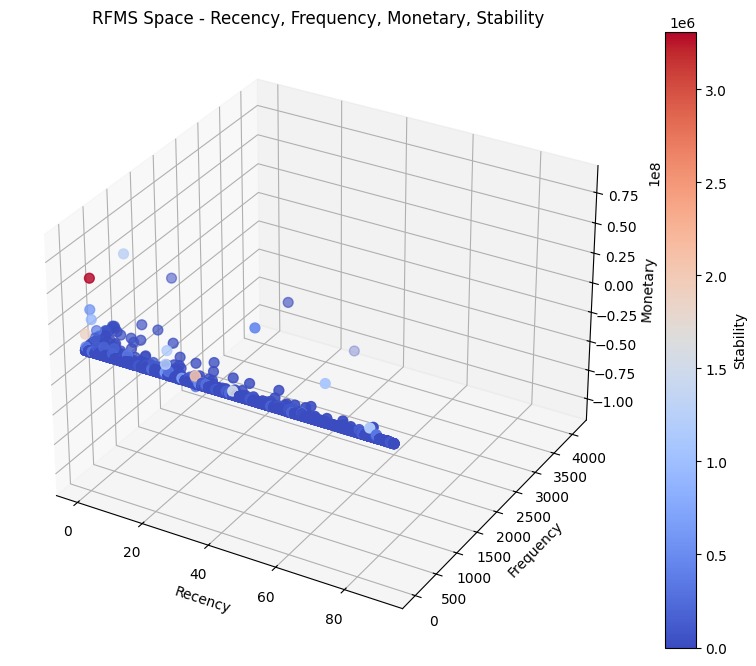

In [6]:
estimator.visualize_rfms(rfms_scores)

## Establishing the Boundary for Good/Bad Classification
a common approach,to define boundaries between high-risk (low RFMS) and low-risk (high RFMS) groups,is to divide customers based on quartiles of their RFMS scores. Assign 1 for High risk and 0 for low risk 

In [7]:
rfms_labeled = estimator.assign_good_bad_labels(rfms_scores)
rfms_labeled.head()

,Recency,Frequency,Monetary,Stability,RiskScore,RiskLabel
CustomerId,,,,,,
CustomerId_1,83,1,-10000.0,0.000000,13945.0,1
CustomerId_10,83,1,-10000.0,0.000000,13945.0,1
CustomerId_1001,89,5,20000.0,6558.963333,8993.5,1
CustomerId_1002,25,11,4225.0,560.498966,8936.0,1
CustomerId_1003,11,6,20000.0,6030.478146,6579.0,0


Binning,Weight of Evidence (WoE) and Information Value(IV)

### merge the prepared data set on the feature engineering section and the customer level data that is used to calculate RFMS score

In [28]:
# data_prepared=pd.read_csv("data/data_prepared.csv")
data=pd.read_csv("data/data.csv")
columns_to_drop = ['TransactionId','TransactionStartTime', 'BatchId', 'AccountId', 'SubscriptionId', 'CurrencyCode', 'CountryCode', 'Value']
data = data.drop(columns=columns_to_drop)

merged_data=estimator.merge_dataframes(data,rfms_labeled)

In [29]:
merged_data.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,PricingStrategy,FraudResult,Recency,Frequency,Monetary,Stability,RiskScore,RiskLabel
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,2,0,0,119,109921.75,3042.294251,2931.0,0
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,2,0,0,119,109921.75,3042.294251,2931.0,0
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,2,0,81,2,1000.00,0.000000,12976.0,1
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,2,0,5,38,228727.20,17169.241610,2167.0,0
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,2,0,5,38,228727.20,17169.241610,2167.0,0


In [30]:
import numpy as np
import pandas as pd
import sidetable
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
merged_data.stb.freq(['ChannelId'], style = True)

,ChannelId,count,percent,cumulative_count,cumulative_percent
0,ChannelId_3,"56,935",59.52%,"56,935",59.52%
1,ChannelId_2,"37,141",38.83%,"94,076",98.34%
2,ChannelId_5,"1,048",1.10%,"95,124",99.44%
3,ChannelId_1,538,0.56%,"95,662",100.00%


In [31]:
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

df=merged_data
# Perform a 70 / 30 split of data
train, test = sc.split_df(df, 'RiskLabel', ratio = 0.7, seed = 999).values()

In [36]:
categorical_columns = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
var = train.drop(['RiskLabel', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy'], axis = 1).columns
y_var = train['RiskLabel']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks

woe_num(var, 'RiskLabel')

AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

In [37]:
import numpy as np
print(np.__version__)

2.0.2


In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from monotonic_binning.monotonic_woe_binning import Binning
# from sklearn.preprocessing import LabelEncoder

# # Example function to calculate WoE and IV for both numerical and categorical features
# def calculate_woe_iv(df, feature, target):
#     # Initialize binning for the feature
#     binning = Binning(y=df[target], n_threshold=50, y_threshold=10, p_threshold=0.35, sign=False)
    
#     # Fit the binning model for the feature
#     binning.fit(df[feature])
    
#     # Transform the feature into WoE bins
#     woe_bins = binning.transform(df[feature], metric='woe')
    
#     # Add WoE bins to the DataFrame
#     df['WoE_Binned_' + feature] = woe_bins
    
#     # Summary statistics of the binning
#     bin_summary = binning.summary(df[feature], df[target])
    
#     # Calculate IV (Information Value)
#     iv = binning.iv(df[feature], df[target])
    
#     return woe_bins, iv, bin_summary

# # Function to plot WoE and bin distribution
# def plot_woe_bin_distribution(bin_summary, feature_name, iv):
#     # Create a figure and axis
#     fig, ax1 = plt.subplots(figsize=(10, 6))
    
#     # Bar plot for bad and good counts
#     bin_summary['Bad_rate'] = bin_summary['Bad'] / (bin_summary['Good'] + bin_summary['Bad'])
#     ax1.bar(bin_summary.index, bin_summary['Total'], label='Total', color='grey', alpha=0.5)
#     ax1.bar(bin_summary.index, bin_summary['Bad'], label='Bad', color='red', alpha=0.6)
#     ax1.bar(bin_summary.index, bin_summary['Good'], label='Good', color='green', alpha=0.6)
    
#     ax1.set_ylabel('Bin count distribution')
    
#     # Plot bad probability on the secondary axis
#     ax2 = ax1.twinx()
#     ax2.plot(bin_summary.index, bin_summary['Bad_rate'], marker='o', color='blue', label='Bad probability')
#     ax2.set_ylim(0, 1)
#     ax2.set_ylabel('Bad probability')
    
#     # Title and legend
#     plt.title(f'{feature_name} (IV: {iv:.3f})')
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
    
#     # Show plot
#     plt.show()

# # Example usage
# def process_and_plot(df, target, features):
#     for feature in features:
#         print(f'Processing feature: {feature}')
#         woe_bins, iv, bin_summary = calculate_woe_iv(df, feature, target)
#         plot_woe_bin_distribution(bin_summary, feature, iv)

# # Load your dataset (replace with actual dataset)
# #df = pd.read_csv('your_data.csv')

# # Define target and features to process
# target = 'RiskLabel'  # Replace with actual target column
# # features = ['Amount', 'ProviderId', 'ProductId']  # Add more features as necessary
# features=['Amount','Recency','Frequency','Monetary','Stability','RiskScore']

# # Apply WoE, IV, and plot
# process_and_plot(merged_data, target, features)


In [11]:
data_prepared_not_encoded=pd.read_csv("data/data_prepared_not_encoded.csv")
merged_data_not_encoded=estimator.merge_dataframes(data_prepared_not_encoded,rfms_labeled)
merged_data_not_encoded=merged_data_not_encoded

In [12]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# def normalize_features(df):
#     numerical_columns=['Amount', 'Recency', 'Frequency', 'Monetary', 'Stability', 'RiskScore']
#     scaler = MinMaxScaler()  # Initialize MinMaxScaler for normalization
#     df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    
#     return df

# merged_data_not_encoded=normalize_features(merged_data_not_encoded)

In [13]:
# import pandas as pd
# import scorecardpy as sc
# from monotonic_binning.monotonic_woe_binning import Binning

# # Perform a 70 / 30 split of data
# train, test = sc.split_df(merged_data_not_encoded, 'RiskLabel', ratio=0.7, seed=999).values()
# encoded_col = ['CustomerId', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 
#                 'TransactionStartTime', 'PricingStrategy', 'FraudResult', 
#                 'TransactionHour', 'TransactionDay', 'TransactionMonth', 
#                 'TransactionYear', 'RiskLabel']

# # Function to compute WOEs
# var = train.drop(encoded_col, axis=1).columns
# y_var = train['RiskLabel']

# def woe_num(x, y, n_threshold=50, y_threshold=10, p_threshold=0.35, sign=False):
#     global breaks
#     breaks = {}

#     # Iterate through each column in x
#     for i in x:
#         try:
#             # Perform qcut binning with an approximate number of bins based on the n_threshold
#             # Using q=n_threshold as a start point
#             quantiles = pd.qcut(train[i], q=n_threshold, duplicates='drop', retbins=True)
            
#             # Get the bin edges (quantile cutpoints)
#             bins = quantiles[1]  # bin edges
#             bin_labels = quantiles[0]  # binned data

#             # Check the number of elements in each bin (apply y_threshold and p_threshold)
#             bin_counts = bin_labels.value_counts()

#             # Filter out bins with fewer than y_threshold values
#             valid_bins = bin_counts[bin_counts >= y_threshold]
#             total_count = len(train[i])

#             # Enforce the p_threshold: remove bins that contain too small a percentage of total data
#             valid_bins = valid_bins[valid_bins / total_count >= p_threshold]

#             # Store the breaks (bin edges)
#             breaks[i] = bins.tolist()[1:-1]  # Exclude the first and last edges (min and max)
#             # print(f"Binning successful for {i}: {breaks[i]}")
            
#         except Exception as e:
#             print(f"Error occurred while processing {i}: {e}")

#     return breaks

# # Example call to the function
# # Assuming 'train' is a DataFrame and 'y' is your target variable
# # breaks = woe_num(['Amount', 'Recency', 'Frequency', 'Monetary', 'Stability', 'RiskScore'], 'RiskLabel')
# breaks = woe_num(var, 'RiskLabel')
# breaks


In [14]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming 'breaks' is a dictionary containing the bin cutoffs for each feature
# # breaks = {'feature1': [bin1, bin2, ...], 'feature2': [bin1, bin2, ...], ...}

# def calculate_woe_iv(df, feature, target, bins):
#     # Use pd.cut to bin the data using the predefined breaks
#     df['binned_feature'] = pd.cut(df[feature], bins=bins, include_lowest=True)
    
#     # Create a cross table for the binned feature and target
#     cross_tab = pd.crosstab(df['binned_feature'], df[target], margins=False)
    
#     # Calculate the distributions of good and bad
#     cross_tab['Total'] = cross_tab.sum(axis=1)
#     cross_tab['Good Dist'] = cross_tab[0] / cross_tab[0].sum()
#     cross_tab['Bad Dist'] = cross_tab[1] / cross_tab[1].sum()

#     # Calculate WoE and IV
#     cross_tab['WoE'] = np.log(cross_tab['Good Dist'] / cross_tab['Bad Dist'])
#     cross_tab['IV'] = (cross_tab['Good Dist'] - cross_tab['Bad Dist']) * cross_tab['WoE']
    
#     # Return the dataframe and the IV sum
#     return cross_tab[['Good Dist', 'Bad Dist', 'WoE', 'IV']], cross_tab['IV'].sum()

# def plot_woe_iv(df, feature, target, bins):
#     # Calculate WoE and IV using the bins
#     woe_iv_df, iv = calculate_woe_iv(df, feature, target, bins)
    
#     # Plotting
#     fig, ax1 = plt.subplots(figsize=(10, 6))
    
#     # Bar plot for the distribution of good and bad
#     woe_iv_df[['Good Dist', 'Bad Dist']].plot(kind='bar', stacked=True, ax=ax1, color=['#00C0A3', '#E87461'])
#     ax1.set_ylabel('Bin count distribution')
#     ax1.set_xlabel(f'{feature} (IV: {round(iv, 3)})')
    
#     # Add percentage labels on top of the bars
#     for i, (good, bad) in enumerate(zip(woe_iv_df['Good Dist'], woe_iv_df['Bad Dist'])):
#         total = good + bad
#         ax1.text(i, total + 0.01, f'{round(total*100, 1)}%, {int(total * len(df))}', ha='center')
    
#     # Line plot for WoE
#     ax2 = ax1.twinx()
#     ax2.plot(woe_iv_df['WoE'], color='blue', marker='o', linestyle='-', label='WoE')
#     ax2.set_ylabel('WoE')
#     ax2.set_ylim([woe_iv_df['WoE'].min() - 0.1, woe_iv_df['WoE'].max() + 0.1])
#     ax2.axhline(0, color='black', linewidth=1)
    
#     # Add WoE value labels
#     for i, woe in enumerate(woe_iv_df['WoE']):
#         ax2.text(i, woe + 0.02, f'{round(woe, 1)}', color='blue', ha='center')
    
#     plt.title(f'WoE and IV Plot for {feature}')
#     plt.show()

# # Example usage with your dataset and bins
# # Assuming 'train' is your DataFrame, 'target_column' is your target, and 'breaks' contains the bin cutoffs for the feature
# feature = 'Amount'
# plot_woe_iv(train, feature, 'RiskLabel', breaks[feature])


In [15]:
# import pandas as pd
# import numpy as np

# def woe_iv_calc(train, target, features, n_threshold=50, y_threshold=10, p_threshold=0.35):
#     # DataFrame to hold WoE and IV values
#     woe_iv_table = pd.DataFrame(columns=['Feature', 'Bin', 'WoE', 'IV'])

#     # Iterate through each feature in the list of features
#     for feature in features:
#         try:
#             # Perform qcut binning (you can use pd.cut for fixed width bins if needed)
#             quantiles = pd.qcut(train[feature], q=n_threshold, duplicates='drop')

#             # Create a table to calculate WoE and IV
#             woe_iv_data = pd.DataFrame({
#                 'Bin': quantiles,
#                 'Target': train[target]
#             })

#             # Calculate the number of events and non-events for each bin
#             bin_counts = woe_iv_data.groupby('Bin')['Target'].agg(['count', 'sum'])
#             bin_counts['non_event'] = bin_counts['count'] - bin_counts['sum']  # non-event = count - event

#             # Calculate the percentage of events and non-events
#             total_events = bin_counts['sum'].sum()
#             total_non_events = bin_counts['non_event'].sum()
#             bin_counts['perc_event'] = bin_counts['sum'] / total_events
#             bin_counts['perc_non_event'] = bin_counts['non_event'] / total_non_events

#             # Calculate WoE for each bin
#             bin_counts['WoE'] = np.log(bin_counts['perc_non_event'] / bin_counts['perc_event'])

#             # Calculate IV for each bin
#             bin_counts['IV'] = (bin_counts['perc_non_event'] - bin_counts['perc_event']) * bin_counts['WoE']

#             # Append the results for this feature to the woe_iv_table
#             for idx, row in bin_counts.iterrows():
#                 woe_iv_table = woe_iv_table.append({
#                     'Feature': feature,
#                     'Bin': idx,
#                     'WoE': row['WoE'],
#                     'IV': row['IV']
#                 }, ignore_index=True)

#             print(f"WoE and IV calculation successful for {feature}")

#         except Exception as e:
#             print(f"Error occurred while processing {feature}: {e}")

#     # Group by feature and sum IV values to get the overall IV per feature
#     iv_summary = woe_iv_table.groupby('Feature')['IV'].sum().reset_index()
#     iv_summary = iv_summary.rename(columns={'IV': 'Total_IV'}).sort_values(by='Total_IV', ascending=False)

#     return woe_iv_table, iv_summary


In [16]:
# # Sample data
# data = pd.DataFrame({
#     'Amount': np.random.rand(1000),
#     'Recency': np.random.rand(1000),
#     'Frequency': np.random.rand(1000),
#     'Monetary': np.random.rand(1000),
#     'Stability': np.random.rand(1000),
#     'RiskScore': np.random.randint(0, 2, 1000),  # Target (binary classification)
# })

# # Features and target column
# features = ['Amount', 'Recency', 'Frequency', 'Monetary', 'Stability']
# target = 'RiskScore'

# # Calculate WoE and IV
# woe_iv_table, iv_summary = woe_iv_calc(data, target, features)

# # Display the WoE/IV table and IV summary
# print(woe_iv_table)
# print(iv_summary)
